### Effect of learning on SPE

In [33]:
import argparse
import os
import sys
import glob
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300

import gymnasium as gym
import miniworld
from miniworld.wrappers import PyTorchObsWrapper,GreyscaleWrapper
import numpy as np


sys.path.append("../models/")
from vae_60_80 import VAE_60_80
from mdrnn import MDRNN

sys.path.append("../utils/")
from plot_functions import plot_video_comparison,plot_SPE_metrics
from torch.distributions.normal import Normal

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

from torch.utils.data import Dataset
class trajectoryDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB 
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    def __len__(self):
        return len(self.datasetA)


device used: cuda


Loading initial model

In [29]:
model_vae_path = "../../saved_models/navigation/model_vae_2023-05-04.pt"

In [30]:
# loading the VAE model


print("loading VAE model saved in", model_vae_path)

vae_params_path_recovery = model_vae_path[:-3] + ".params.yml"
with open(vae_params_path_recovery) as file:
    parameters = yaml.load(file, Loader=yaml.FullLoader)
print("using VAE parameters from " + vae_params_path_recovery)

vae_model = VAE_60_80(
    img_channels=parameters["img_channels_vae"],
    latent_dim=parameters["latent_dim_vae"],
    beta=parameters["beta_vae"],
)
vae_model.load_state_dict(torch.load(model_vae_path))
vae_model.to(device)
print("number of parameters in vae :", count_parameters(vae_model))
vae_model.load_state_dict(torch.load("../../saved_models/navigation/model_vae_2023-05-04.pt"))

loading VAE model saved in ../../saved_models/navigation/model_vae_2023-05-04.pt
using VAE parameters from ../../saved_models/navigation/model_vae_2023-05-04.params.yml
number of parameters in vae : 1963625


<All keys matched successfully>

random rollout data shape : (100000, 60, 80, 1)


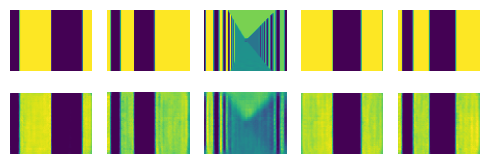

In [31]:
# testing the VAE model

import random
import matplotlib.pyplot as plt

# import random rollout data from the Task-Hallway environment
data = np.load("../../data/navigation/randomRollout.npy")
data = data / 255
print("random rollout data shape :",data.shape)
sample_index = np.random.randint(data.shape[0],size=5)
sample = data[sample_index]

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()


imgs_tensor = torch.tensor(sample).to(device).float().unsqueeze(1).squeeze(-1)
out_tensor, mu, logsigma = vae_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()
imgs_tensor = imgs_tensor.cpu().detach().numpy()
plot_video_comparison(imgs_tensor.squeeze(1),out.squeeze(1))

Load models saved over the training

In [41]:
model_name="model_mdrnn_rollout_constant_gain_to_rollout_changing_gain_straight_2023-05-05"
model_epoch_files = glob.glob('../../saved_models/navigation/'+model_name+'*.pt')
model_params_path= '../../saved_models/navigation/' + model_name + ".params.yml"
with open(model_params_path) as file:
    model_parameters = yaml.load(file, Loader=yaml.FullLoader)

mdrnn_model = MDRNN(
            latent_dim=model_parameters["latent_dim_mdrnn"],
            action_dim=model_parameters["action_dim_mdrnn"],
            hidden_dim=model_parameters["hidden_dim_mdrnn"],
            gaussians_nb=model_parameters["gaussians_nb_mdrnn"],
        ).to(device)
print("number of parameters :", count_parameters(mdrnn_model))

number of parameters : 24873


In [43]:

def gmm_loss(batch,mus,sigmas,logpi):

    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)

    return - log_prob


def run_model_prediction(video,act):

    loss = []
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,60,80)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = vae_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,60,80))

    if mdrnn_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(1,batch_size, mdrnn_model.hidden_dim).to(device),
                        torch.zeros(1,batch_size, mdrnn_model.hidden_dim).to(device))

    actions = torch.transpose(torch.tensor(act),0,1).to(device)
    
    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]
        action = actions[t,:,:]

        if mdrnn_model.memory == 'rnn':

            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden

        if t < seq_len-1 :
            loss.append( gmm_loss(latent_video[t+1,:,:],mus,sigmas,logpi).cpu().detach().numpy() )


        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    loss = np.stack(loss).T
    predicted_latent = torch.tensor(mean_pred).to(device)
    predicted_latent = torch.reshape(predicted_latent,(-1,20))
    predicted_video = vae_model.decoder(predicted_latent)
    predicted_video = torch.reshape(predicted_video,(seq_len,batch_size,60,80))
    
    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    predicted_video = predicted_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss

def run_test_mdrnn(env,nb_control_trajectories=100):
    
    control_args = dict(
            nb_sections=1,
            random_gain = False,
            motor_gains=[1],
            sections_length=[50],
            max_episode_steps=100,
        )

    nb_control_trajectories = 100

    trajectories_observations = []


    for i_traj in range(nb_control_trajectories):

        gains = [1,0.5,1,1.5,0.5,1.5,1]
        gain_change_steps = [0,15,30,45,60,75,90]

        observations = []
        observation, info = env.reset()

        for i_step in range(control_args['max_episode_steps']-1):

            if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :

                env.change_gain(random=False,gain=gains[0])
                gain_change_steps.pop(0)
                gains.pop(0)

            action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                print("oups")
                observation, info = env.reset()

            observations.append(observation)

        observations = np.stack(observations).squeeze(-1)
        actions = np.ones(control_args['max_episode_steps'])*2

        trajectories_observations.append(observations)
        
    env.close()

    trajectories_observations = np.stack(trajectories_observations) / 255
    trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
    trajectories_actions[:,:,2] = 1
    trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
    trajectories_observations = np.array(trajectories_observations,dtype=np.float32)
    
    reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)


    z = np.mean(latent_video, axis=0).T
    z_pred = np.mean(mean_pred, axis=0).T

    # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
    z_error = np.abs(z_pred[:, :-1] - z[:, 1:])

    return loss,z_error



def run_test_mdrnn_2(env,nb_control_trajectories = 10,
                     gains_test = [0.5,1,1.5],
                     nb_steps = 50):
    # split by gain change amplitude
    
    control_args = dict(
            nb_sections=1,
            random_gain = False,
            motor_gains=[1],
            sections_length=[50],
            max_episode_steps=nb_steps+2,
        )
    """
    env = gym.make('MiniWorld-TaskHallwayControl-v0', 
                    view="agent", render_mode=None,
                    **control_args)
    env = GreyscaleWrapper(env)
    """
    # losses = np.zeros((3,3,nb_control_trajectories,nb_steps))
    # SPE_norms = np.zeros((3,3,nb_control_trajectories,nb_steps))

    losses = np.zeros((3,3,nb_control_trajectories,20))
    SPE_norms = np.zeros((3,3,nb_control_trajectories,20))

    traj_steps = np.random.randint(15,35,size=nb_control_trajectories)

    loss_0 = []
    loss_m1 = []
    loss_m2 = []
    loss_1 = []
    loss_2 = []

    SPE_0 = []
    SPE_m1 = []
    SPE_m2 = []
    SPE_1 = []
    SPE_2 = []

    random_change_step = True

    for i,gain_pre in enumerate(gains_test) :
        for j,gain_post in enumerate(gains_test):

            trajectories_observations = []

            for i_traj in range(nb_control_trajectories):
                
                gains = [gain_pre,gain_post]
                if random_change_step :
                    gain_change_steps = [0,traj_steps[i_traj]]
                else :
                    gain_change_steps = [0,15]
                observations = []
                observation, info = env.reset()
                for i_step in range(control_args['max_episode_steps']-1):
                    if (len(gain_change_steps) > 0) and (i_step == gain_change_steps[0]) :
                        env.change_gain(random=False,gain=gains[0])
                        gain_change_steps.pop(0)
                        gains.pop(0)
                    action = 2 # env.action_space.sample()  # agent policy that uses the observation and info
                    observation, reward, terminated, truncated, info = env.step(action)
                    if terminated or truncated:
                        print("oups")
                        observation, info = env.reset()
                    observations.append(observation)

                observations = np.stack(observations).squeeze(-1)
                actions = np.ones(control_args['max_episode_steps'])*2

                trajectories_observations.append(observations)
                

            trajectories_observations = np.stack(trajectories_observations) / 255
            trajectories_actions = np.zeros((nb_control_trajectories,control_args['max_episode_steps'],3))
            trajectories_actions[:,:,2] = 1
            trajectories_actions = np.array(trajectories_actions,dtype=np.int32)
            trajectories_observations = np.array(trajectories_observations,dtype=np.float32)

            reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred,predicted_video,loss = run_model_prediction(trajectories_observations,trajectories_actions)

            z = latent_video
            z_pred = mean_pred

            # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
            z_error = np.abs(z_pred[:,:-1,:] - z[:,1:,:])
            spe_norm = np.linalg.norm(z_error,axis=-1)

            for i_traj in range(nb_control_trajectories):
                losses[i,j,i_traj] = loss[i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10]
                SPE_norms[i,j,i_traj] = spe_norm[i_traj,traj_steps[i_traj]-10:traj_steps[i_traj]+10]
            
            if i-j == 0:
                loss_0.append(loss)
                SPE_0.append(spe_norm)
            elif i-j == -1:
                loss_m1.append(loss)
                SPE_m1.append(spe_norm)
            elif i-j == -2:
                loss_m2.append(loss)
                SPE_m2.append(spe_norm)
            elif i-j == 1:
                loss_1.append(loss)
                SPE_1.append(spe_norm)
            else :
                loss_2.append(loss)
                SPE_2.append(spe_norm)

    env.close()

    # relative_gain_changes_losses = [loss_m2,loss_m1,loss_0,loss_1,loss_2] 
    # relative_gain_changes_spe = [SPE_m2,SPE_m1,SPE_0,SPE_1,SPE_2]
    # return(losses,SPE_norms,traj_steps,relative_gain_changes_losses,relative_gain_changes_spe)

    loss_avg = np.mean(losses,axis=(0,1,2))
    SPE_avg = np.mean(SPE_norms,axis=(0,1,2))
    return (loss_avg, SPE_avg)

In [44]:
epoch_losses = []
z_errors = []
epoch_center_losses = []
epoch_center_spe = []

control_args = dict(
            nb_sections=1,
            random_gain = False,
            motor_gains=[1],
            sections_length=[50],
            max_episode_steps=100,
        )
env = gym.make('MiniWorld-TaskHallwayControl-v0', 
                    view="agent", render_mode=None,
                    **control_args)
env = GreyscaleWrapper(env)

for model_file in tqdm(model_epoch_files) :
    mdrnn_model.load_state_dict(torch.load(model_file))
    # run the standard test
    loss,z_error = run_test_mdrnn(env,nb_control_trajectories=10)
    epoch_losses.append(loss)
    z_errors.append(z_error)

    # run the other test
    avg_loss,avg_spe = run_test_mdrnn_2(env,nb_control_trajectories=2)
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.26 GiB (GPU 0; 6.00 GiB total capacity; 4.18 GiB already allocated; 0 bytes free; 4.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import matplotlib as mpl

colors = plt.cm.jet(np.linspace(0.1,0.9,len(epoch_losses)))
norm = mpl.colors.Normalize(
    vmin=1,
    vmax=len(epoch_losses)+1)

plt.figure(figsize=(15,5))

plt.subplot(121)

for i in range(len(epoch_losses)):
    plt.plot(np.mean(epoch_losses[i],axis=0),color=colors[i],lw=3)
plt.xlabel('timesteps')
plt.ylabel('loss signal')


sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
c =plt.colorbar(sm)
c.set_label('epoch')

plt.subplot(122)

for i in range(len(epoch_losses)):
    z_error_norm = np.linalg.norm(z_errors[i], axis=0)
    plt.plot(z_error_norm,color=colors[i],lw=2)
    plt.title(r"$||z_{t+1} - ẑ_{t+1}||$")
    plt.xlabel('timesteps')
plt.show()

In [ ]:
f = plt.figure(figsize=(15,5))

plt.subplot(121)
for i in range(len(epoch_losses)):
    plt.plot(epoch_center_spe[i].T,color=colors[i],lw=2)
    plt.xlabel('timesteps')

plt.subplot(122)
for i in range(1,len(epoch_losses)):
    plt.plot(epoch_center_losses[i].T,color=colors[i],lw=2)
    plt.xlabel('timesteps')